# Word-level translator using LSTMs

This notebook shows how to train with Amazon SageMaker an NLP model that translates from English to a series of languages. The list of languages is limited by the available training data.

The model uses an LSTM based encoder / decoder architeecture, inspired by https://github.com/hlamba28/Word-Level-Eng-Mar-NMT.

The training time depends on the dataset available. Typically an epoch is trained in 30 minutes for small datasets (for example, Hungarian) and 1.5 - 2 hours for big datasets (for example, Italian). With 15-20 epochs you can already get an acceptable result.

The dataset was created from a curated list of anki flash cards (https://ankiweb.net/shared/decks/). Each translated sentences is annotated with CC license string.


In [ ]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os, sys
import json

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from pathlib import Path
import time

sys.path.append('./src')

from utils import preproc, load_vocab, save_vocab

## Download dataset

In [69]:
def extract_fields(l):
    l = l.strip()
    elems = l.split(' - ')
    source_name = elems[0]
    elems = elems[1].split()
    target_name = elems[0]
    file_name = elems[1]
    num_sentences = elems[2].strip('()')
    base_name = file_name.split('.')[0]
    source_code, target_code = base_name.split('-')
    return source_name, source_code, target_name, target_code, file_name, num_sentences
    
with open('./dataset/language_list.txt') as f:
    data = [extract_fields(l) for l in f]
    cols = ['source_name', 'source_code', 'target_name', 'target_code', 'file_name', 'num_sentences']
    df = pd.DataFrame(data, columns=cols)

df

,source_name,source_code,target_name,target_code,file_name,num_sentences
0,Afrikaans,afr,English,eng,afr-eng.zip,904
1,Albanian,sqi,English,eng,sqi-eng.zip,448
2,Algerian Arabic,arq,English,eng,arq-eng.zip,156
3,Arabic,ara,English,eng,ara-eng.zip,12156
4,Assamese,asm,English,eng,asm-eng.zip,1963
...,...,...,...,...,...,...
77,Ukrainian,ukr,English,eng,ukr-eng.zip,155019
78,Urdu,urd,English,eng,urd-eng.zip,1146
79,Uyghur,uig,English,eng,uig-eng.zip,281
80,Vietnamese,vie,English,eng,vie-eng.zip,8050


In [ ]:
# Download all possible language pairs

dataset_path = Path('dataset')

!mkdir -p {dataset_path}

ip = get_ipython()
for lang_code in df['source_code']:
    ip.system(
    f'''cd {dataset_path} && \
        curl -O http://www.manythings.org/anki/{lang_code}-eng.zip && \
        cd -
    ''')
    time.sleep(1)

## Select target language code

In [78]:
lang_code = 'ita'

## Preprocessing

In [79]:
import zipfile
with zipfile.ZipFile(dataset_path / f'{lang_code}-eng.zip') as archive:
    with archive.open(f'{lang_code}.txt') as f:
        lines = pd.read_table(f, names=['eng', lang_code, 'attrib'])
lines = lines[['eng', lang_code]]
lines.shape

(354238, 2)

In [80]:
lines['eng'] = lines['eng'].apply(preproc)
lines[lang_code] = lines[lang_code].apply(preproc)

# Add start and end tokens to target sequences
lines[lang_code] = lines[lang_code].apply(lambda x : 'START_ '+ x + ' _END')
lines.sample(10)

,eng,ita
322525,tom asked me how to get to marys house,START_ tom mi ha chiesto come arrivare a casa ...
88966,i bought tom a clock,START_ ho comprato un orologio per tom _END
43067,we told everyone,START_ noi labbiamo detto a tutti _END
281477,maybe its best not to add pepper,START_ forse è meglio non aggiungere del pepe ...
254369,are you good at keeping secrets,START_ tu sei bravo a mantenere i segreti _END
223327,tom seems to be really happy,START_ tom sembra essere veramente felice _END
79304,she knows who he is,START_ sa chi è lui _END
550,we lost,START_ perdemmo _END
292395,tom left boston in october of,START_ tom lasciò boston nellottobre del _END
264503,whats the purpose of your trip,START_ qual è lo scopo del vostro viaggio _END


## Create training dataset

In [ ]:
def get_vocab(sentences):
    vocab = set()
    for text in sentences:
        vocab.update(text.split())
    return vocab

all_source_words = get_vocab(lines['eng'])
all_target_words = get_vocab(lines[lang_code])
num_encoder_tokens = len(all_source_words)
num_decoder_tokens = len(all_target_words)
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens
print(f'num_encoder_tokens: {num_encoder_tokens}')
print(f'num_decoder_tokens: {num_decoder_tokens}')

In [ ]:
def get_max_length(sentences):
    res = 0
    for text in sentences:
        res = max(res, len(text.split(' ')))
    return res

max_length_src = get_max_length(lines['eng'])
max_length_tar = get_max_length(lines[lang_code])
print(f'source sentences max length: {max_length_src}')
print(f'target sentences max length: {max_length_tar}')

In [ ]:
input_words = sorted(list(all_source_words))
target_words = sorted(list(all_target_words))

In [ ]:
lines = shuffle(lines)
lines.head(10)

In [ ]:
X, y = lines['eng'], lines[lang_code]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape

In [ ]:
!mkdir -p input/train
!mkdir -p input/test
!mkdir -p input/vocab

In [ ]:
save_vocab(input_words, 'input/vocab/source.txt')
save_vocab(target_words, 'input/vocab/target.txt')

In [ ]:
input_token_index, reverse_input_index = load_vocab('input/vocab/source.txt')
target_token_index, reverse_target_index = load_vocab('input/vocab/target.txt')

In [ ]:
np.save('input/train/x.npy', X_train)
np.save('input/train/y.npy', y_train)
np.save('input/test/x.npy', X_test)
np.save('input/test/y.npy', y_test)

In [ ]:
meta = {
    'max_length_source': max_length_src,
    'max_length_target': max_length_tar
}
with open('input/vocab/meta.json', 'w') as f:
    json.dump(meta, f)

## Test training locally

In [73]:
from types import SimpleNamespace

In [ ]:
!mkdir -p model

In [ ]:
args = SimpleNamespace(
    epochs=30,
    batch_size=4,
    latent_dim=50,
    verbose=1,
    model_save_dir='./model',
    train_dir='./input/train',
    test_dir='./input/test',
    vocab_dir='./input/vocab'
)

from train import train
train(args)

## Upload training data to S3

In [ ]:
import sagemaker
import boto3

# region = 'us-east-1'
region = 'us-west-2'

boto_session = boto3.Session(region_name=region)

session = sagemaker.Session(boto_session=boto_session)
role = sagemaker.get_execution_role()
session.boto_region_name

In [ ]:
prefix = f'lstm-translator-{lang_code}'

train_input_path   = session.upload_data('input/train', key_prefix=prefix+'/train')
test_input_path    = session.upload_data('input/test', key_prefix=prefix+'/test')
vocab_input_path   = session.upload_data('input/vocab', key_prefix=prefix+'/vocab')

## Launch SageMaker training job

In [ ]:
from sagemaker.tensorflow import TensorFlow

local = False

local_hps = {
    'epochs': 1,
    'batch-size': 1,
    'latent-dim': 20
}

train_hps = {
    'epochs': 30,
    'batch-size': 64,
    'latent-dim': 50
}

tf_estimator = TensorFlow(
    source_dir='src',
    entry_point='train.py', 
    role=role,
    instance_count=1, 
    instance_type='local' if local else 'ml.g4dn.2xlarge',
    framework_version='2.8', 
    py_version='py39',
    script_mode=True,
    hyperparameters=local_hps if local else train_hps,
    sagemaker_session=session,
    metric_definitions=[
        {'Name': 'train:loss', 'Regex': 'loss:\s([\d\.]*?)\s'},
        {'Name': 'train:accuracy', 'Regex': 'acc:\s([\d\.]*?)\s'},
        {'Name': 'val:loss', 'Regex': 'val_loss:\s([\d\.]*?)\s'},
        {'Name': 'val:accuracy', 'Regex': 'val_acc:\s([\d\.]*?)\s'}
    ]
)


In [ ]:
tf_estimator.fit({
    'train': train_input_path, 
    'test': test_input_path,
    'vocab': vocab_input_path
})

## Download trained model

In [ ]:
!aws s3 cp s3://{session.default_bucket()}/{tf_estimator.jobs[0].name}/output/model.tar.gz ./model
!cd model && tar -xvf model.tar.gz

## Local inference

In [ ]:
from inference import Predictor

In [ ]:
selected_weights = './model/weights-16.hdf5'

In [ ]:
predictor = Predictor(latent_dim=50, vocab_dir='./input/vocab', weights_file=selected_weights)

In [63]:
predictor.predict('Tom is still learning.')

'tom sta ancora imparando'

In [64]:
predictor.predict('Did they say why?')

'hanno detto perché'

In [65]:
predictor.predict('I am going to school.')

'io vado a scuola'

In [66]:
predictor.predict('Tom borrowed a book from Mary.')

'tom ha preso in prestito un libro da mary'

In [67]:
predictor.predict('I feed my dog.')

'io ho miei cani da mangiare'

<font size="10">🧐</font>

### Draw model's architecture

In [ ]:
%pip install pydot
%pip install pydotplus
!sudo yum -y install graphviz
from tensorflow.keras.utils import plot_model

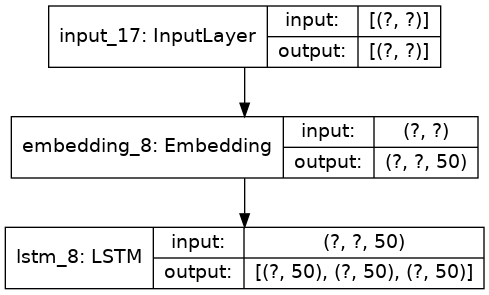

In [81]:
image = plot_model(predictor.encoder_model, show_shapes=True)
image.width = 350
image

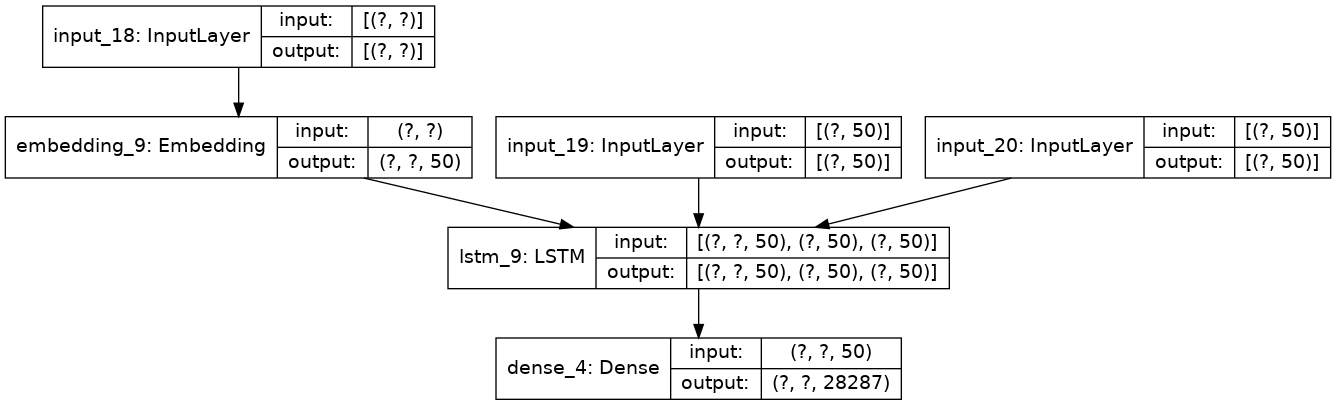

In [82]:
image = plot_model(predictor.decoder_model, show_shapes=True)
image.width = 1000
image